#### GDAA2030 Image Analytics - Assignment 4

Submitted By: Tiana Gallo

Submitted To: James Rapaport

Due Date: April 17, 2024


**Introduction**

The aim of this assignment is to analyze crop yield using the NDVI vegetation index. This will be done on a broad scale using low spatial resolution data. While the data will have a low spatial resolution of 1km, the sensor has a high temporal resolution. The study area is Prince Edward Island and is refined by reference to a second dataset named the Annual Crop Inventory. The aim will be to select the NDVI for pixels with a high proportion of potato crop area, according to the ACI. 

In [1]:
import pyproj
import rasterio 
import rasterio.mask
import numpy as np
import os
import zipfile
import rasterio
import shapely
import json
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.features import rasterize
from rasterio.transform import from_origin
from shapely.geometry import shape, mapping
from shapely.ops import transform
from zipfile import ZipFile
from rasterio.transform import Affine
from shapely.geometry import shape, mapping
from rasterio.warp import calculate_default_transform, reproject
from shapely.geometry import box



## Task 1

**Reprojection**

The first step in this project is to perform a reprojection of multiple annual crop inventory (ACI) datasets to match the coordinate reference system of an eVIIRS dataset. The eVIIRS dataset was opened using rasterio and it's CRS was extracted in order to be used as the target CRS for reprojection. Then, each year from 2013 - 2023 was iterated over and a file path was constructed to the corresponding ACI dataset. Still within the for loop, the ACI dataset was opened and the 'transform' function was used to match the CRS and dimensions of the eVIIRS dataset. The metadata for the ACI data was updated in order to reflect the new CRS, transformation, width and height. Then, each band of the ACI dataset was looped through and reprojected to match the CRS of the eVIIRS dataset, and was written to the output dataset.

In [2]:

aci_directory = 'C:/geospatial/assignment4_TG/annual-crop-inventory/'
output_directory = 'C:/geospatial/assignment4_TG/reprojected-aci/'
eviirs_zip_path = 'C:/geospatial/assignment4_TG/eviirs-ndvi-20231203.zip'
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

with rasterio.open(f'zip+file://{eviirs_zip_path}!GN_eVSH_NDVI.2013.121-130.1KM.VI_NDVI.001.2023098064738.tif') as eviirs:
    target_crs = eviirs.crs

for year in years:
    aci_zip_path = os.path.join(aci_directory, f'aci_{year}_pe.zip')
    output_path = os.path.join(output_directory, f'reprojected_aci_{year}_pe.tif')

    with rasterio.open(f'zip+file://{aci_zip_path}!/aci_{year}_pe.tif') as aci:
        transform, width, height = calculate_default_transform(
            aci.crs, target_crs, aci.width, aci.height, *aci.bounds)
        
        meta = aci.meta.copy()
        meta.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(output_path, 'w', **meta) as output:
            for i in range(1, aci.count + 1):
                reproject(
                    source=rasterio.band(aci, i),
                    destination=rasterio.band(output, i),
                    src_transform=aci.transform,
                    src_crs=aci.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest)


print(output.crs) 
print(eviirs.crs) 

EPSG:4326
EPSG:4326


**Cropping**

The next step in this project is to perform the cropping of the reprojected ACI datasets using the bounding box of the eVIIRS dataset. The bounds were extracted from the eVIIRS dataset and a polygon representing the bounding box was created. Again, the years from 2013 - 2023 were iterated over and a file path for the inputs and outputs were created using each year.

In [3]:
from rasterio.mask import mask
cropped_directory = 'C:/geospatial/assignment4_TG/cropped_aci/'

# Open the eVIIRS dataset to get its bounding box
with rasterio.open(f'zip+file://{eviirs_zip_path}!GN_eVSH_NDVI.2013.121-130.1KM.VI_NDVI.001.2023098064738.tif') as eviirs:
    # Create a bounding box polygon from the eVIIRS dataset
    bbox = box(*eviirs.bounds)
    bbox_geojson = json.loads(json.dumps(bbox.__geo_interface__))

# Loop through each year to crop the reprojected ACI datasets
for year in years:
    input_path = os.path.join(output_directory, f'reprojected_aci_{year}_pe.tif')
    output_path = os.path.join(cropped_directory, f'cropped_aci_{year}_pe.tif')
    
    # Check if the input reprojected ACI dataset exists
    if os.path.exists(input_path):
        # Open the reprojected ACI dataset
        with rasterio.open(input_path) as src:
            # Mask the reprojected ACI dataset using the bounding box
            out_image, out_transform = mask(src, [bbox_geojson], crop=True)
            out_meta = src.meta.copy()
            
            # Update metadata
            out_meta.update({"driver": "GTiff",
                             "height": out_image.shape[1],
                             "width": out_image.shape[2],
                             "transform": out_transform})
            
            # Write the cropped image
            with rasterio.open(output_path, "w", **out_meta) as dest:
                dest.write(out_image)
    else:
        print(f"Input file {input_path} does not exist.")


**Calculate Proportion of Potato Fields**

This next code chunk processes each year of the cropped ACI dataset and calculates the proportion of potato fields for each pixl in the eVIIRS image. It iterates through each pixel in the eVIIRS image and calculates the corresponding geometry for each pixel. The cropped ACI dataset had a mask applied using the geometry, cropping it to the extent of the pixel. Then the number of pixels with the value of 177, which indicates potato fields was counted, therefore calculating the proportion of potato fields for each pixel. The potato proportions were written to a new output raster dataset. 

In [4]:
raster_directory = 'C:/geospatial/assignment4_TG/'


# Open the eVIIRS image to get its dimensions, pixel size, and CRS
with rasterio.open(f'zip+file://{eviirs_zip_path}!GN_eVSH_NDVI.2013.121-130.1KM.VI_NDVI.001.2023098064738.tif', 'r') as eviirs:
    eviirs_transform = eviirs.transform
    eviirs_width = eviirs.width
    eviirs_height = eviirs.height

    # List of years for which ACI data is available
    years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

    # Loop through the specified list of years
    for current_year in years:
        aci_file_path = os.path.join(cropped_directory, f'cropped_aci_{current_year}_pe.tif')

        with rasterio.open(aci_file_path, 'r') as aci:
            potato_proportion = np.zeros((eviirs_height, eviirs_width), dtype=np.float32)
            for row in range(eviirs_height):
                for col in range(eviirs_width):
                    x, y = eviirs_transform * (col, row) 
                    pixel_geom = box(x, y, x + eviirs_transform.a, y + eviirs_transform.e)
                    geojson_geom = mapping(pixel_geom)

                    # Use the geometry to mask the ACI dataset, cropping to the extent of the pixel
                    try:
                        out_image, out_transform = mask(aci, [geojson_geom], crop=True)
                        potato_pixels = np.count_nonzero(out_image == 177)
                        total_pixels = out_image.size 

                        if total_pixels > 0:
                            potato_proportion[row, col] = (potato_pixels / total_pixels) * 100
                        else:
                            potato_proportion[row, col] = np.nan  
                    except ValueError:
                        potato_proportion[row, col] = np.nan

            # Define the output raster file name
            raster_file_name = os.path.join(raster_directory, f'potato_raster_{current_year}.tif')

            # Write the proportion of potato fields to the new raster dataset
            with rasterio.open(
                raster_file_name,
                'w',
                driver='GTiff',
                width=eviirs_width,
                height=eviirs_height,
                count=1,
                dtype='float32',
                crs=eviirs.crs,
                transform=eviirs_transform
            ) as potato_raster:
                potato_raster.write(potato_proportion, 1)


## Task 2

The aim of task 2 is to produce a linear regression model plotting time-integrated NDVI against known potato yield. It will make use of the mask produced in task 1 to find pixels with a high proportion of potato cropping. The aci threshold is set to 75. I attempted to use a threshold of 80, but the largest percentage in my mask dataset for 2023 is 77.1, which is why I ended up setting the threshold to 75. Next we connect to the SQLite database that contains our agricultural data and fetches the average yield for potatoes in Prince Edward Island. In the main loop, each year is iterated over and a file path for the corresponding ACI file is constructed. The integrated NDVI is then calcualted for each year, and the average yield is also printed. Lastly, 'integrated_ndvi_values' and 'average_yield_values_ are converted from lists to numpy arrays. 

In [10]:
import os
import glob
import numpy as np
import rasterio
from rasterio.mask import mask
from shapely.geometry import box, mapping
import json
from scipy.integrate import trapz
import sqlite3
import zipfile
import rasterio.features
from rasterio.features import shapes


aci_directory = 'C:/geospatial/assignment4_TG/annual-crop-inventory'
cropped_directory = 'C:/geospatial/assignment4_TG/cropped_aci'
eviirs_directory = 'C:/geospatial/assignment4_TG/eviirs-ndvi-20231203' 
years = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

 
# Define the threshold for potato proportion
threshold = 75

# Initialize empty lists to store NDVI and yield values
integrated_ndvi_values = [] 
average_yield_values = [] 
 
# Function to find all eVIIRS GeoTIFF files for a given year
def find_eviirs_files(year):
    pattern = f'GN_eVSH_NDVI.{year}*.tif'
    file_paths = glob.glob(os.path.join(eviirs_directory, pattern))
    file_paths = [path for path in file_paths if 'QUAL' not in os.path.basename(path)]
    return file_paths
 
 
# Function to calculate integrated NDVI profile for all files found for a given year
def calculate_integrated_ndvi_profile(crop_filename, year, threshold):
    integrated_ndvi_profile = []
    day_numbers = []  
 
    # Find all eVIIRS files for the year
    file_paths = find_eviirs_files(year)
    for file_path in file_paths:
        day_numbers.append(int(file_path.split('.')[2][4:7]))  
        try:
            with rasterio.open(file_path) as eviirs_ndvi:
                with rasterio.open(crop_filename, 'r') as crop_proportion:
                    ndvi_data = eviirs_ndvi.read(1)
                    crop_proportion_mask = crop_proportion.read(1) >= threshold
                    ndvi_data = ndvi_data * crop_proportion_mask
                    mean_ndvi = np.mean(ndvi_data[ndvi_data != 0]) / 10000  
                    integrated_ndvi_profile.append(mean_ndvi)
        except Exception as e:
            print(f"Error processing file {file_path}: {e}")
 
    # Integrate the NDVI profile using trapz, with dx representing the number of days between images if known or 1 as default
    integrated_ndvi = trapz(integrated_ndvi_profile, day_numbers)  # Adjust dx as needed
    integrated_ndvi_values.append(integrated_ndvi)
 
    return integrated_ndvi

 
# Connect to the SQLite database
conn = sqlite3.connect(r'C:\geospatial\assignment4_TG\statistics-canada\statistics-canada.db')
cursor = conn.cursor()
 
# Loop through each year
for current_year in years:
    aci_file_path = os.path.join(raster_directory, f'potato_raster_{current_year}.tif')
    integrated_ndvi = calculate_integrated_ndvi_profile(aci_file_path, current_year, threshold)
 
    # Fetch yield data for the current year
    cursor.execute("""
        select year, name, average_yield
        from potato_production 
        where year = ? and name = 'Prince Edward Island'
        order by year
    """, (current_year,))
    
    
    result = cursor.fetchone()
    if result:
        year, name, average_yield = result
        print(f"Year: {year}, Average Yield: {average_yield}")
        average_yield_values.append(average_yield)
    else:
        print(f"No data found for year {current_year}")
 
# Close the SQLite connection
conn.close()

#Convert lists to numpy arrays
integrated_ndvi_array = np.array(integrated_ndvi_values)
average_yield_array = np.array(average_yield_values)



Year: 2013, Average Yield: 301.7
Year: 2014, Average Yield: 298.0
Year: 2015, Average Yield: 291.3
Year: 2016, Average Yield: 296.7
Year: 2017, Average Yield: 294.0
Year: 2018, Average Yield: 285.4
Year: 2019, Average Yield: 289.3
Year: 2020, Average Yield: 251.5
Year: 2021, Average Yield: 322.0
Year: 2022, Average Yield: 334.0
Year: 2023, Average Yield: 311.0


The last step is to generate a yield model using a scatter plot and linear regression. The dependent variables on the y-axis is yield and the independent variable on the x-axis is integrated NDVI. A function 'predict(x)' is defned to predict the potato yield based on the integrated NDVI using the calculated slope and intercept. By using the 'predict()' function, a regression line is generated based on the calculated slope and intercept. 

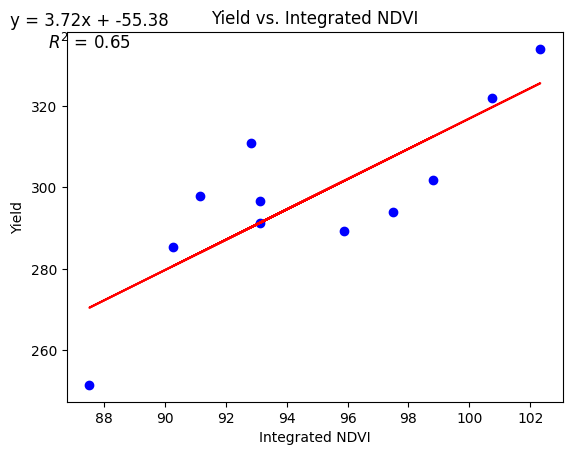

In [11]:

import matplotlib.pyplot as plt
from scipy.stats import linregress
 
ndvi = integrated_ndvi_array
potato_yield = average_yield_array
 
# Check if inputs are not empty and have more than one element
if ndvi.size > 1 and potato_yield.size > 1:
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(ndvi, potato_yield)
 
    # Predict function
    def predict(x):
        return slope * x + intercept
 
    # Generate regression line
    fit_line = predict(ndvi)
 
    # Plotting
    plt.scatter(ndvi, potato_yield, color='blue')  # Data points
    plt.plot(ndvi, fit_line, color='red')  # Regression line
    plt.xlabel('Integrated NDVI')
    plt.ylabel('Yield')
    plt.title('Yield vs. Integrated NDVI')
    plt.text(min(ndvi), max(potato_yield), f'y = {slope:.2f}x + {intercept:.2f}\n$R^2$ = {r_value**2:.2f}', fontsize=12, ha='center')
    plt.show()
else:
    print("Error: Not enough data points for regression analysis.")

The final graph shows the linear regression output from my analysis. It shows a linear relationship between potato yield and integrated NDVI. The R squared value is 0.65 indicating that NDVI accounts for only around 60% of the variation in yield. There are multiple other environmental variables that could be included to improve the relationship such as soil pH, temperature, and rainfall amounts. Slope could also be taken into account as it affects factors such as solar radiation, moisture availability, and soil charactersitics that can have an influence on vegetation. Other than feature engineering to add additional features in order to improve the model, I could also have preprocessed the data to evaluate it for outliers, missing data, or skewness. Implementing cross-validation techniques to assess the generalization performance of the model and mitigate overfitting could also enhance the model's performance. There are multiple other changes and different approcahes that could be used to refine the linear model regression, but overall I find it very interesting to use these types of models to demonstrate their predictive capabilites for estimateing potato yield based on integrated NDVI values. 